In [75]:
import jsonpickle
import numpy as np
import requests
from pprint import pprint
import cv2
from PIL import Image
from bounding_box import bounding_box as bb
from pycocotools import mask as decode_mask

## Object Detection

Because of memory constraints I only use a mock prediction object here.

In [76]:
IMG_F = '/home/sharif/Documents/sp2-ai-e2e/test.png'
w,h = 800,450

In [77]:
loadedImage = cv2.imread(IMG_F)
resized = cv2.resize(loadedImage, (w,h))
print(resized.shape)
img = jsonpickle.encode(resized)
image = Image.fromarray(resized)

(450, 800, 3)


In [84]:
od = '/home/sharif/Documents/sp2-ai-e2e/object_detection.npy'
od = np.load(od, allow_pickle='TRUE').item()

In [85]:
bboxes = []
coo_persons = []
coo_vehicles = []

In [86]:
for b in od['trackersPersons']:
    pos = b['position']
    x1, y1, x2, y2 = pos['px1'], pos['py1'], pos['px2'], pos['py2']
    crop = image.crop((x1, y1, x2, y2))
    bboxes.append([crop, 'person'])
    coo_persons.append([x1, y1, x2, y2, crop.size])

In [87]:
for b in od['trackersVehicles']:
    pos = b['position']
    x1, y1, x2, y2 = pos['px1'], pos['py1'], pos['px2'], pos['py2']
    crop = image.crop((x1, y1, x2, y2))
    bboxes.append([crop, 'vehicle'])
    coo_vehicles.append([x1, y1, x2, y2, crop.size])

In [89]:
for i, roi in enumerate(coo_persons):
    bb.add(resized, roi[0],roi[1],roi[2],roi[3], "0")

for i, roi in enumerate(coo_vehicles):
    bb.add(resized, roi[0],roi[1],roi[2],roi[3], "1")

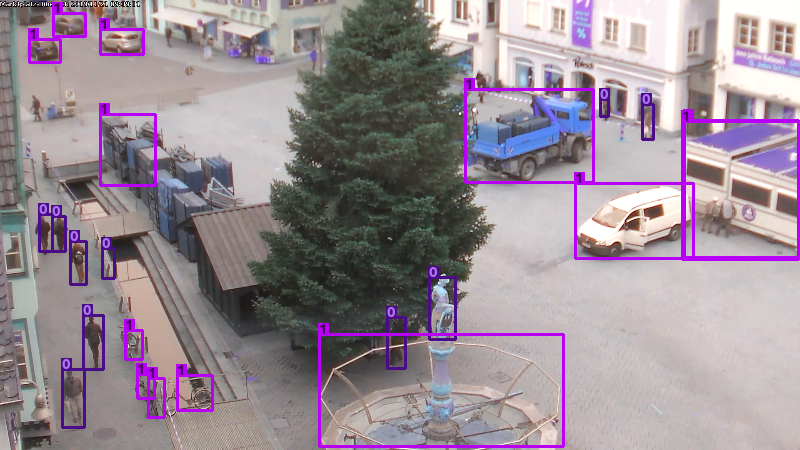

In [90]:
Image.fromarray(resized)

## Semantic Segmenatation

In [91]:
PORT = 20001
URL = f'http://0.0.0.0:{PORT}/api/v1/predict'
IMG_F = 'test.png'
w,h = 100,100

In [92]:
images = []
classes = []

In [93]:
for b in bboxes:
    img = np.array(b[0].resize((w, h))).reshape(3, w, h)
    img = jsonpickle.encode(img)
    images.append(img)
    classes.append(b[1])

In [94]:
len(images), len(classes)

(23, 23)

In [95]:
headers = {'Accept' : 'application/json', 'Content-Type' : 'application/json'}

In [96]:
json_content = {'image': images, 'classes': classes, 'timestamp':'12788901', 'sensorId': 0}

In [97]:
res = requests.post(URL, json=json_content, headers=headers)

In [98]:
json_res = res.json()
pprint(json_res)

{'predictions': [{'class': 'person',
                  'mask': 'ed77m23XMG^2`001N1010O1O012AlT1',
                  'size': [100, 100]},
                 {'class': 'person', 'mask': '`h9', 'size': [100, 100]},
                 {'class': 'person',
                  'mask': 'e1Z1k1O00001N100O2O000O0O2O0O2O1N2O001O1O010O0ZORN7<El01oN56Ki0OVO220Y21O0000000\\NM73IM73IN62JN62JN61_10000O10000001O000000000000000000000000000000000000001O0000001O000mMLV14jNMU13kNOS11lN4P1KQO7m0ISO8l0HSO:@En00C<]OEP1ND?YODS1MCb0XOAU1LDl0<TOCm0=SOCm0=SOCm0=SOBm0?SOAn0Z1O2M3L4L3I8HcQ1',
                  'size': [100, 100]},
                 {'class': 'person',
                  'mask': 'c^11R31O2O00O100000000O100Omo21PPM3nMLV12jNNW10iN1U21O00001O00000001O001O1Oba2',
                  'size': [100, 100]},
                 {'class': 'person', 'mask': '`h9', 'size': [100, 100]},
                 {'class': 'person', 'mask': '`h9', 'size': [100, 100]},
                 {'class': 'person',
                  'mask': 'ad1

In [99]:
vehicles = []
persons = []

In [100]:
for i, seg in enumerate(json_res['predictions']):
    c = seg['class']
    m = seg['mask']
    
    t = {'size': [w, h], 'counts': m}
    dm = decode_mask.decode(t)
    
    if c == 'vehicle': vehicles.append([c, dm])        
    if c == 'person': persons.append([c, dm])

In [111]:
resized_vehicle_masks = []
resized_persons_masks = []

In [112]:
for i, person in enumerate(persons):
    og_sz = coo_persons[i]
    m = person[1]
    resized_mask = cv2.resize(m, og_sz[4])
    resized_vehicle_masks.append([resized_mask, og_sz])

In [113]:
for i, person in enumerate(persons):
    og_sz = coo_persons[i]
    m = person[1]
    resized_mask = cv2.resize(m, og_sz[4])
    resized_persons_masks.append([resized_mask, og_sz])

In [125]:
fullFrame = np.zeros((450, 800), dtype='uint8')

In [126]:
for m in resized_persons_masks:
    mask = m[0]
    x1, y1, x2, y2 = m[1][0],m[1][1],m[1][2],m[1][3]
    fullFrame[y1:y2, x1:x2] = mask

In [127]:
for m in resized_vehicle_masks:
    mask = m[0]
    x1, y1, x2, y2 = m[1][0],m[1][1],m[1][2],m[1][3]
    fullFrame[y1:y2, x1:x2] = mask

In [132]:
def vis_mask(img, mask, col, alpha=0.4, show_border=True, border_thick=2):
    """Visualizes a single binary mask."""

    img = img.astype(np.float32)
    idx = np.nonzero(mask)

    img[idx[0], idx[1], :] *= 1.0 - alpha
    img[idx[0], idx[1], :] += alpha * np.array(col)

    if show_border:
        contours = cv2.findContours(
            mask.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)[-2]
        cv2.drawContours(img, contours, -1, col, border_thick, cv2.LINE_AA)

    return img.astype(np.uint8)

In [133]:
vis = vis_mask(resized, fullFrame, [255,255,255])

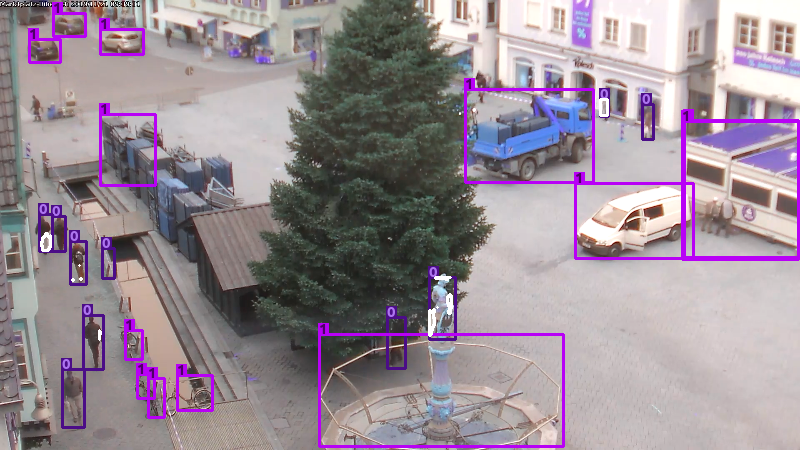

In [134]:
Image.fromarray(vis)